In [102]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
import datetime as dt
from sklearn import preprocessing
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
from scipy.stats import probplot
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
%matplotlib inline

In [7]:
from pathlib import Path
DATA_PATH = Path() / "../data"
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_data(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

def save_data(data, filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False,encoding='ISO-8859-1')

PLOT_PATH = Path() / "../plot"
PLOT_PATH.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

In [8]:
data = pd.read_csv('ifood_df.csv')
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [98]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

# Model Building Based on RFM Analysis

In [16]:
# Renaming the variables of recency
data.rename(columns={'Recent_Purchase': 'Recency'}, inplace=True)

# Calculating Frequency
data['Frequency'] = data['NumStorePurchases'] + data['NumCatalogPurchases'] + data['NumWebPurchases']

# Calculating Monetory
data['Monetory'] = data['MntWines'] + data['MntSweetProducts'] + data['MntMeatProducts']+ data['MntGoldProds'] + data['MntFruits'] + data['MntFishProducts'] 

data.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall', 'Frequency', 'Monetory'],
      dtype='object')

In [18]:
data_rfm = pd.DataFrame(data[['Recency','Frequency','Monetory']])
quantiles_recency = data_rfm.quantile(q = [0.2,0.4,0.6,0.8])
quantiles_recency

,Recency,Frequency,Monetory
0.2,19.0,5.0,55.0
0.4,39.0,9.0,198.0
0.6,58.4,15.0,636.4
0.8,79.0,20.0,1174.0


In [23]:
quantiles_recency = data_rfm.quantile(q = [0.2,0.4,0.6,0.8])

# Creating functions to determine the RFM score:
def R_score(data):
    if data < quantiles_recency['Recency'][0.2]:
        return 4
    elif data < quantiles_recency['Recency'][0.4]:
        return 3
    elif data < quantiles_recency['Recency'][0.6]:
        return 2
    elif data < quantiles_recency['Recency'][0.8]:
        return 1
    else:
        return 0
    
def F_score(data):
    if data < quantiles_recency['Frequency'][0.2]:
        return 4
    elif data < quantiles_recency['Frequency'][0.4]:
        return 3
    elif data < quantiles_recency['Frequency'][0.6]:
        return 2
    elif data < quantiles_recency['Frequency'][0.8]:
        return 1
    else:
        return 0
    
def M_score(data):
    if data < quantiles_recency['Monetory'][0.2]:
        return 4
    elif data < quantiles_recency['Monetory'][0.4]:
        return 3
    elif data < quantiles_recency['Monetory'][0.6]:
        return 2
    elif data < quantiles_recency['Monetory'][0.8]:
        return 1
    else:
        return 0

In [25]:
data_rfm['R_score'] = data_rfm.Recency.apply(lambda x : R_score(x))
data_rfm['F_score'] = data_rfm.Frequency.apply(lambda x : F_score(x))
data_rfm['M_score'] = data_rfm.Monetory.apply(lambda x : M_score(x))
data_rfm['rfm_score'] = data_rfm['R_score'].map(str) + data_rfm['F_score'].map(str) + data_rfm['M_score'].map(str) 

data_rfm.head()

,Recency,Frequency,Monetory,R_score,F_score,M_score,rfm_score
0,58,22,1617,2,0,0,200
1,38,4,27,3,4,4,344
2,26,20,776,3,0,1,301
3,26,6,53,3,3,4,334
4,94,14,422,0,2,2,022


<Axes: ylabel='Density'>

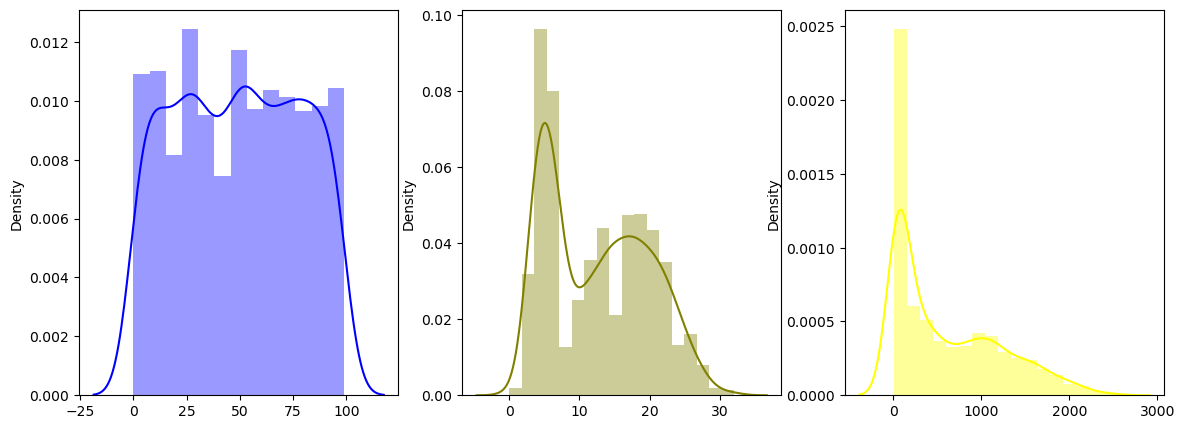

In [ ]:
# Determining the distributions of variables
warnings.filterwarnings("ignore")

plt.figure(figsize = (14,5))

plt.subplot(1,3, 1)
sns.distplot(x = data_rfm['Recency'], kde = True, color = 'blue')

plt.subplot(1,3,2)
sns.distplot(x = data_rfm['Frequency'], kde = True, color = 'olive')

plt.subplot(1,3,3)
sns.distplot(x = data_rfm['Monetory'], kde = True, color = 'yellow')

In [28]:
data_rfm.skew()

# The result shows that "Recent_Purchase" and "Frequency" are between [-0.5, 0.5], which means that both are symmetric.
# While, "Monetory" shows a long skewness with a value of 0.860.

Recency     -0.001874
Frequency    0.292470
Monetory     0.859552
R_score      0.002442
F_score      0.007384
M_score     -0.000968
rfm_score    0.002772
dtype: float64

In [95]:
df_log = data_rfm.copy()
df_log['Monetory'] = np.log1p(df_log['Monetory'])

In [32]:
# Normalizing the data :
scaler = preprocessing.MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_log[['Recency','Frequency','Monetory']]))
df_norm.columns = ['Recency','Frequency','Monetory']

df_norm.head()

,Recency,Frequency,Monetory
0,0.585859,0.6875,0.926283
1,0.383838,0.1250,0.254929
2,0.262626,0.6250,0.804894
3,0.262626,0.1875,0.363620
4,0.949495,0.4375,0.704265


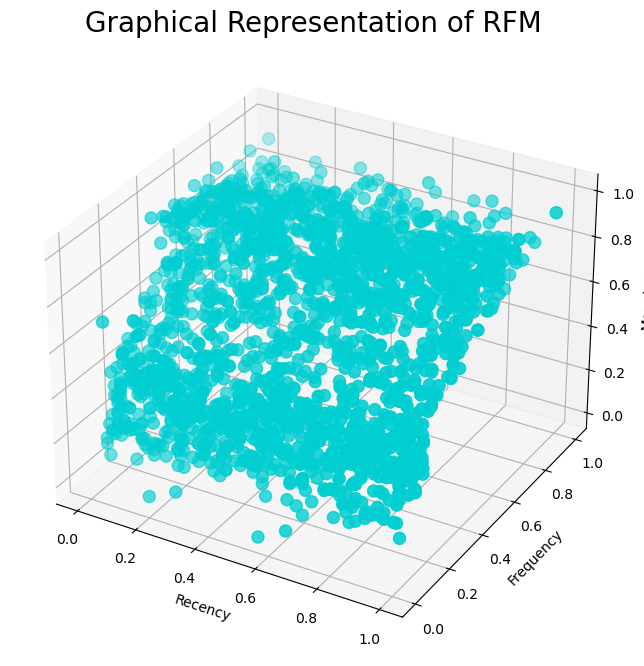

In [36]:
# Graphical representation of RFM
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

im = ax.scatter(df_norm["Recency"],df_norm["Frequency"],df_norm["Monetory"],
               color = 'darkturquoise',s = 75)       
plt.title('Graphical Representation of RFM ',fontsize = 20)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetory")
plt.show()

# Clustering

## K-Means Clustering Algorithm

In [46]:
def Kmeans_algo(data,n):
    """ Function for Kmeans Clustering."""
    
    kmeans_model = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300,
                         random_state = 0, algorithm = 'elkan')
    kmeans_model.fit(data)
    
    #creating centroids:
    centroids = kmeans_model.cluster_centers_
    
    #creating labels:
    labels = kmeans_model.labels_
    df_norm['label'] = labels
    
    #evaluation metrics:
    interia = kmeans_model.inertia_
    sil_score = metrics.silhouette_score(data, labels)
    
    return interia, labels, centroids, sil_score

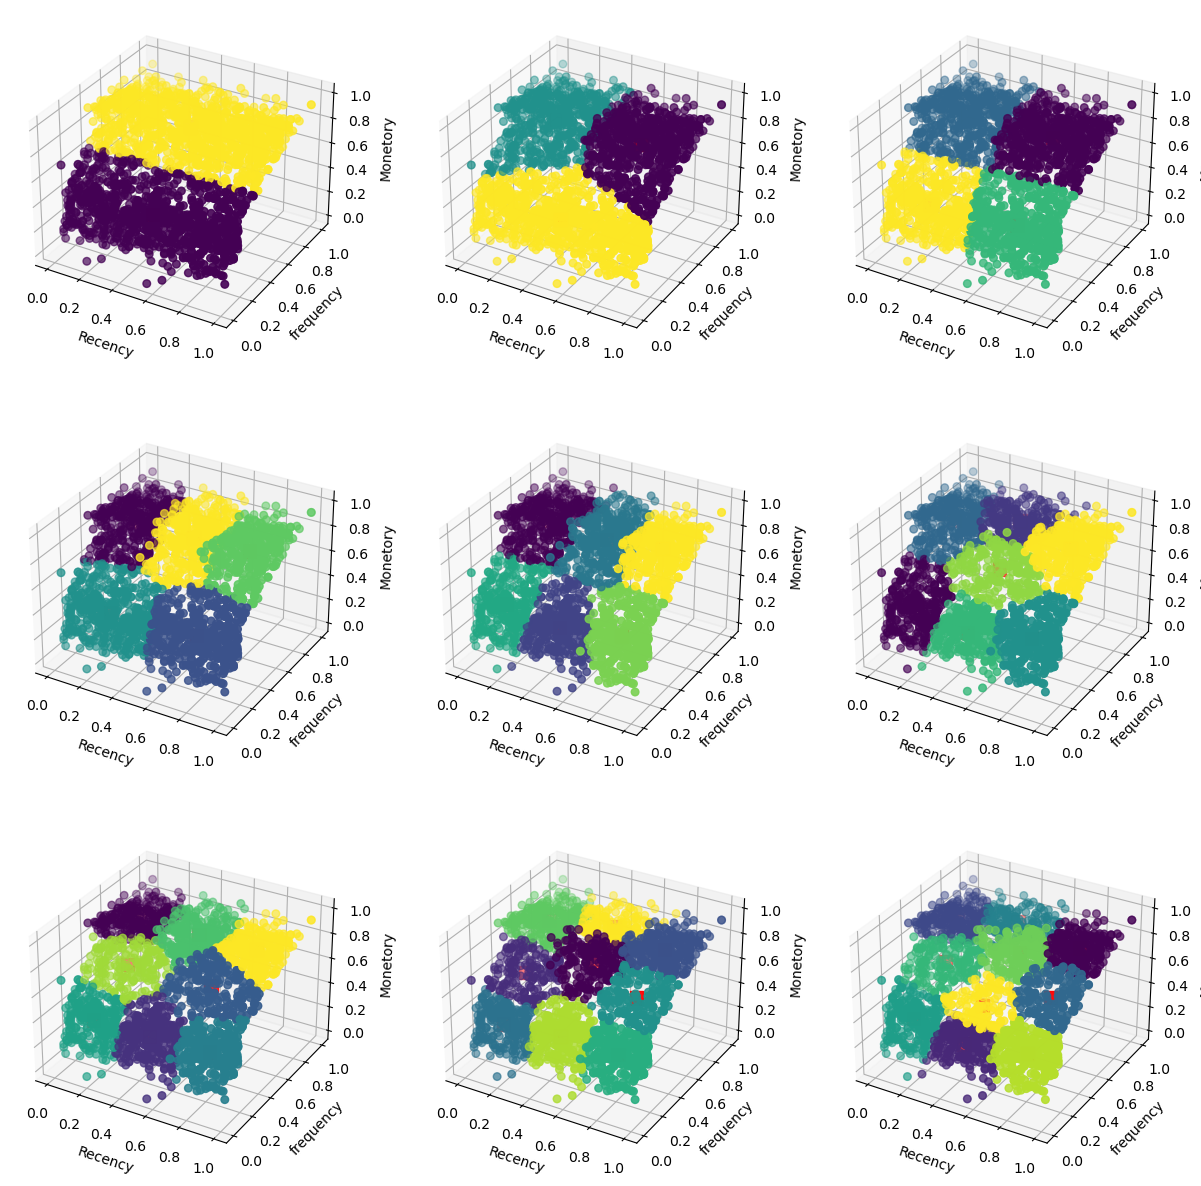

In [50]:
# creating a dataframe :
x3 = df_norm[['Recency','Frequency','Monetory']]

x3_interia_score = []
x3_s_score = []

fig = plt.figure(figsize = (15,15))

#call the function :
for i in range(2,11):
    x3_interia, x3_lables, x3_centroids, x3_sil_score = Kmeans_algo(x3, i)
    x3_interia_score.append(x3_interia)
    x3_s_score.append(x3_sil_score)
    centroids_df = pd.DataFrame(x3_centroids, columns = ['Recency','Frequency','Monetory'])
    
    ax = fig.add_subplot(330 + i - 1, projection='3d')
    
    #scatter plot:
    ax.scatter(df_norm['Recency'],df_norm['Frequency'],df_norm['Monetory'],
                s = 30, c = df_norm["label"], cmap = "viridis")
    ax.scatter(centroids_df['Recency'], centroids_df['Frequency'], centroids_df['Monetory'], 
               s = 90, marker= ",", color = "r")
    ax.set_xlabel('Recency')
    ax.set_ylabel('frequency')
    ax.set_zlabel('Monetory')

Text(0, 0.5, 'Inertia Values')

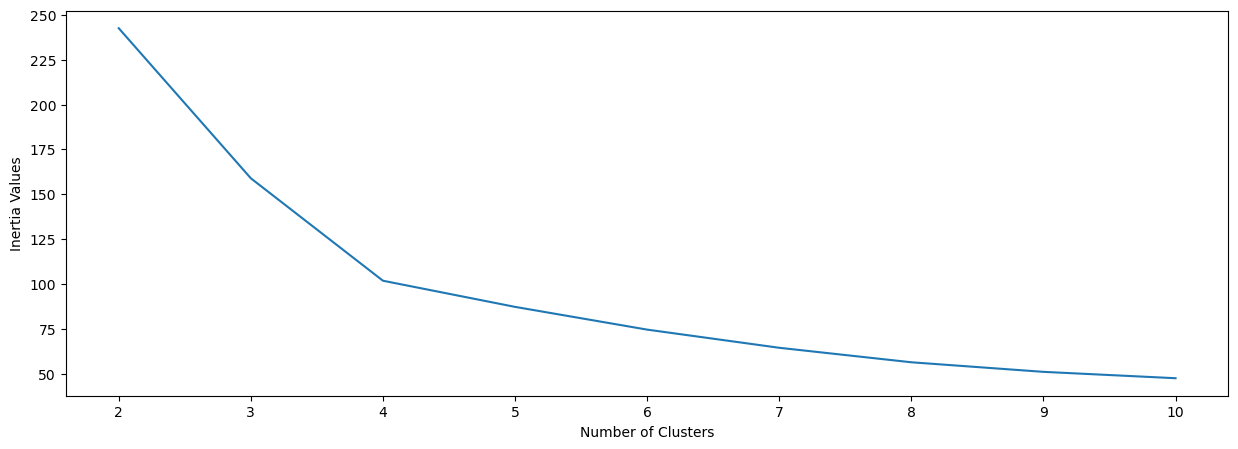

In [58]:
# HyperParameter Tuning
# 1. Elbow method
plt.figure(11, figsize = (15,5))
plt.plot(np.arange(2,11), x3_interia_score, '-')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Values")    
# The plot shows a clear elbow at k = 4.

Text(0, 0.5, 'Silhouette Score')

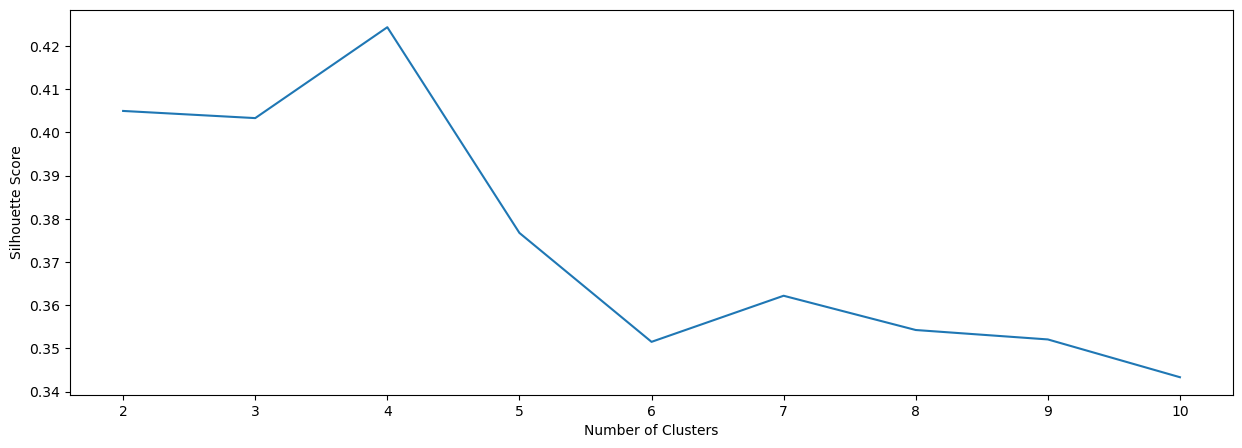

In [59]:
# 2. Silhouette Method
plt.figure(11, figsize=(15,5))
plt.plot(np.arange(2,11) , x3_s_score)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
# There is a clear peak at k = 4.

In [60]:
d1 = df_norm[['Recency','Frequency','Monetory']]
model1 = KMeans(n_clusters = 4, max_iter = 400, random_state = 0)
model1.fit(d1)
d1['labels'] = model1.labels_

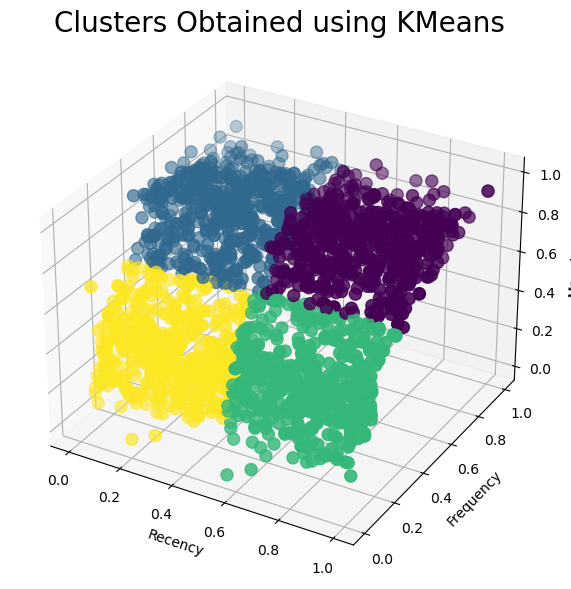

In [62]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(d1["Recency"], d1["Frequency"], d1["Monetory"],
               c = model1.labels_ , cmap = "viridis" ,s = 75)       
plt.title('Clusters Obtained using KMeans',fontsize = 20)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetory")
plt.show()

In [63]:
score1 = metrics.silhouette_score(d1[['Recency','Frequency','Monetory']], model1.labels_, metric='euclidean')
c1 = metrics.calinski_harabasz_score(d1[['Recency','Frequency','Monetory']], model1.labels_)
print(f'''
score1 = {score1}
c1 = {c1}
''')


score1 = 0.4243188381508971
c1 = 2359.2162542795977



In [64]:
data['kmeans_labels'] = model1.labels_
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Frequency,Monetory,kmeans_labels
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,1,0,0,1529,1441,0,22,1617,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,1,0,0,21,15,0,4,27,3
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,1,0,0,734,692,0,20,776,1
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,1,0,0,48,43,0,6,53,3
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,1,407,392,0,14,422,0


## DBSCAN Algorithm

In [66]:
df_dbscan = df_norm[['Recency','Frequency','Monetory']]
df_dbscan.head()

,Recency,Frequency,Monetory
0,0.585859,0.6875,0.926283
1,0.383838,0.1250,0.254929
2,0.262626,0.6250,0.804894
3,0.262626,0.1875,0.363620
4,0.949495,0.4375,0.704265


In [67]:
Mnt_pnts = len(df_dbscan.columns)*2
print('The Minimum Points under Consideration is :', Mnt_pnts)

The Minimum Points under Consideration is : 6


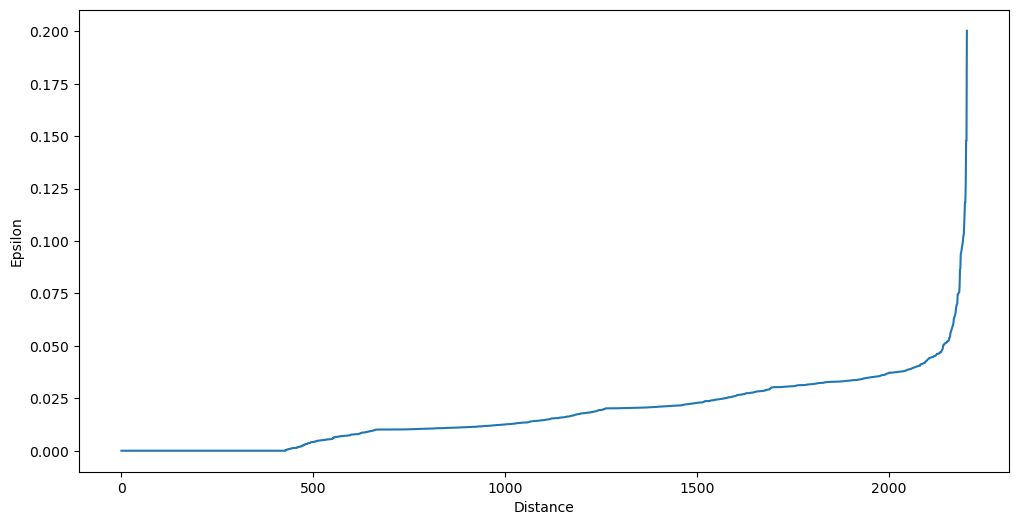

In [68]:
# Determine the optimal value for Epsilon
# Firstly, finding average distance using KNN:
neighbours = NearestNeighbors(n_neighbors = Mnt_pnts)
knn_data = neighbours.fit(df_dbscan)

#Obtaining indices and distances :
distances, indices = knn_data.kneighbors(df_dbscan)

#Sorting the distance:
sorting_distance = np.sort(distances, axis = 0)

#sorted distance
sorted_distance = sorting_distance[:,1]

#plotting between epsilon and distance
plt.figure(figsize = (12,6))
plt.plot(sorted_distance)
plt.xlabel('Distance')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
# The ideal value for ε will be equal to the distance value at the “crook of the elbow”
# So the ideal value chose for Epsilon will be 0.05.

In [70]:
# Creating a dataframe and using DBSCAN algorithm:
x1 = df_dbscan[['Recency','Frequency','Monetory']]
dbscan_model = DBSCAN(eps = 0.05, min_samples = Mnt_pnts).fit(df_dbscan)
df_dbscan['labels'] = dbscan_model.labels_
print('The Number of Clusters Obtained will be :')
print(df_dbscan['labels'].value_counts())

#calculating Silhoutte Score:
print("")
score = metrics.silhouette_score(x1, dbscan_model.labels_)
print("The Silhoutte Score is:", score)

The Number of Clusters Obtained will be :
 0     1809
-1      207
 1       73
 2       39
 3       21
 4       15
 6        6
 11       6
 7        6
 9        5
 10       5
 8        5
 5        4
 12       4
Name: labels, dtype: int64

The Silhoutte Score is: -0.3216754540716497


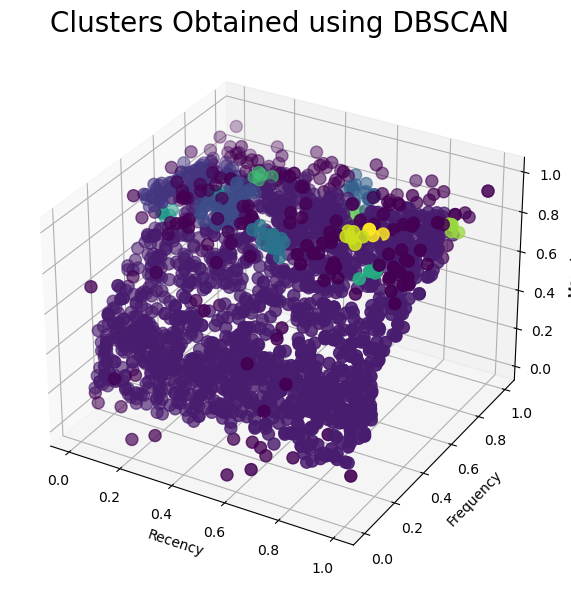

In [72]:
#plotting :
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(df_dbscan["Recency"],df_dbscan["Frequency"],df_dbscan["Monetory"],
               c = df_dbscan["labels"] , cmap ="viridis",s = 75)       
plt.title('Clusters Obtained using DBSCAN',fontsize = 20)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetory")
plt.show()

In [75]:
d2 = df_dbscan[['Recency','Frequency','Monetory']]
model2 = DBSCAN(eps = 0.05, min_samples = Mnt_pnts)
model2.fit(d2)

DBSCAN(eps=0.05, min_samples=6)

In [76]:
score2 = metrics.silhouette_score(d2, model2.labels_, metric='euclidean')
c2 = metrics.calinski_harabasz_score(d2, model2.labels_)
print(f'''
score2 = {score2}
c2 = {c2}
''')


score2 = -0.3216754540716497
c2 = 28.058486019999034



In [77]:
data['dbscan_labels'] = model2.labels_
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Frequency,Monetory,kmeans_labels,dbscan_labels
0,58138.0,0,0,58,635,88,546,172,88,88,...,1,0,0,1529,1441,0,22,1617,0,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,1,0,0,21,15,0,4,27,3,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,734,692,0,20,776,1,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,48,43,0,6,53,3,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,1,407,392,0,14,422,0,0


## Agglomerative Hierarchical clustering

In [79]:
df_agglo = df_norm[['Recency','Frequency','Monetory']]
df_agglo.head()

,Recency,Frequency,Monetory
0,0.585859,0.6875,0.926283
1,0.383838,0.1250,0.254929
2,0.262626,0.6250,0.804894
3,0.262626,0.1875,0.363620
4,0.949495,0.4375,0.704265


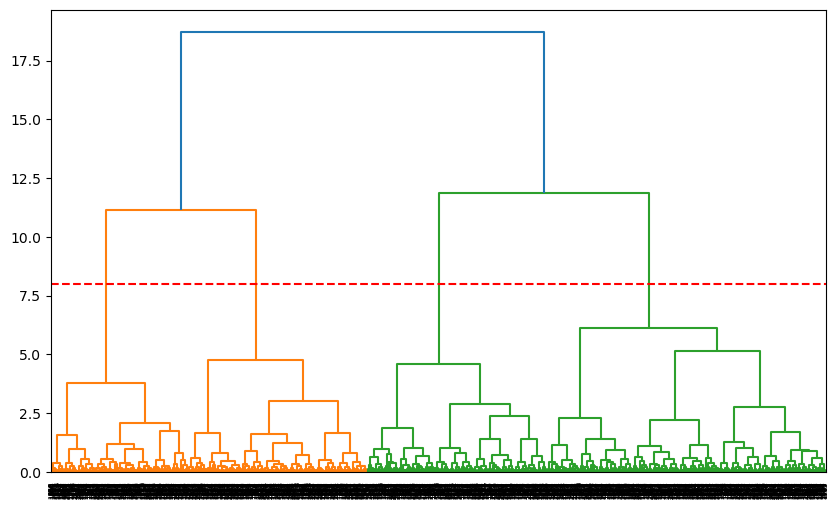

In [80]:
# Determine the number of clusters
plt.figure(figsize = (10,6))
shc.dendrogram(shc.linkage(df_agglo, method='ward'))
plt.axhline(y = 8, color='r', linestyle='--')
plt.show()

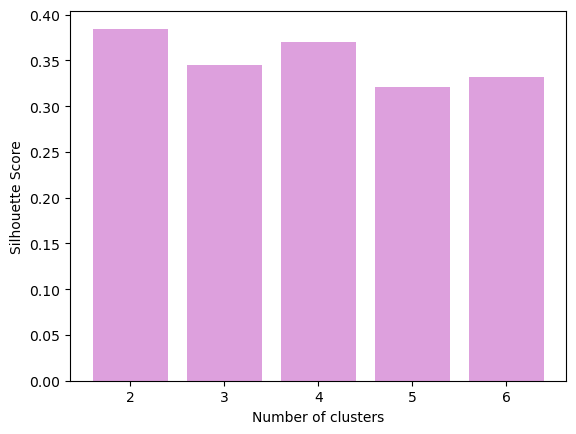

In [81]:
#validation
agglo_s_score = []
x1 = df_agglo[['Recency','Frequency','Monetory']]

for n_cluster in range(2,7):
    agglo_s_score.append(metrics.silhouette_score(x1, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(x1))) 
    
k = [2, 3, 4, 5, 6] 
plt.bar(k,agglo_s_score, color = 'plum' ) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show()

In [ ]:
# The number of Clusters is chosen to be 4.

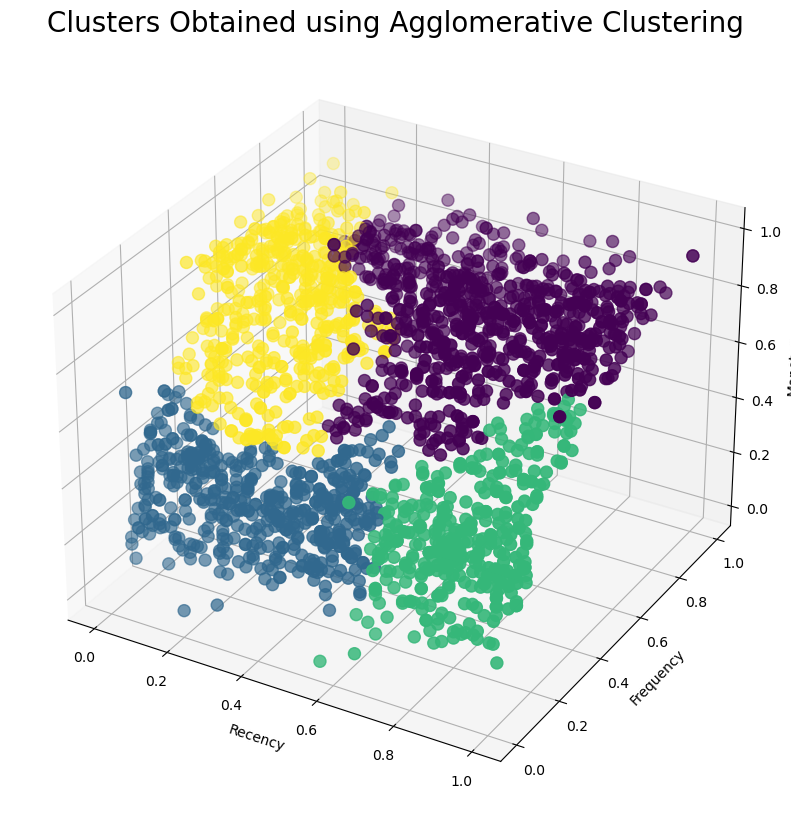

In [84]:
x1 = df_agglo[['Recency','Frequency','Monetory']]

agglo_hier_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward') 
agglo_hier_model.fit(df_agglo)
df_agglo['labels'] = agglo_hier_model.labels_

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = '3d')
ax.scatter(df_agglo["Recency"],df_agglo["Frequency"],df_agglo["Monetory"],
               c = df_agglo['labels'], cmap ="viridis",s = 75) 

plt.title('Clusters Obtained using Agglomerative Clustering',fontsize = 20)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetory")
plt.show()

In [86]:
d3 = df_agglo[['Recency','Frequency','Monetory']]
model3 = AgglomerativeClustering(n_clusters = 4, affinity='euclidean', linkage='ward') 
model3.fit(d3)

AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [89]:
score3 = metrics.silhouette_score(d3, model3.labels_, metric='euclidean')
c3 = metrics.calinski_harabasz_score(d3, model3.labels_)
print(f'''
score3 = {score3}
c3 = {c3}
''')


score3 = 0.36997670287473605
c3 = 1868.3077078856504



In [90]:
data['agglo_labels'] = model3.labels_
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Frequency,Monetory,kmeans_labels,dbscan_labels,agglo_labels
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,1529,1441,0,22,1617,0,0,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,21,15,0,4,27,3,0,1
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,734,692,0,20,776,1,0,2
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,48,43,0,6,53,3,0,1
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,1,407,392,0,14,422,0,0,3


## Validation of the Clustering algorithms

In [91]:
#dataframe of Silhoutte Score:
validation_df = pd.DataFrame({'Algorithms': ['KMeans','DBSCAN',"Agglomerative Clustering"],
                              "Silhouette Score": [score1, -score2, score3]})

# dataframe of calinski:
validation_df_cal = pd.DataFrame({'Algorithms': ['KMeans','DBSCAN',"Agglomerative Clustering"],
                              "Calinski Score": [c1,c2,c3]})

<Axes: xlabel='Algorithms', ylabel='Calinski Score'>

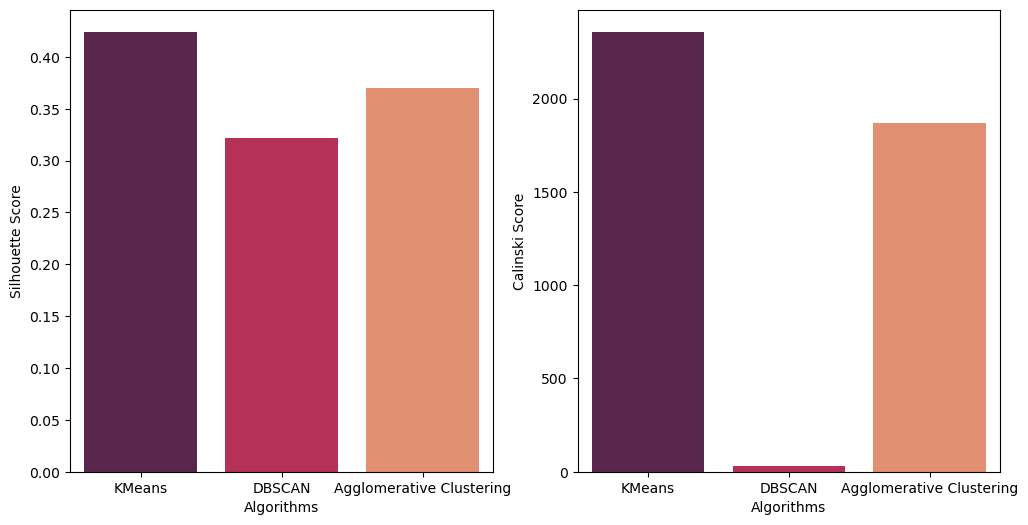

In [92]:
plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.barplot(x = validation_df['Algorithms'], y = validation_df['Silhouette Score'], 
              palette = 'rocket')

plt.subplot(1,2,2)
sns.barplot(x = validation_df_cal['Algorithms'], y = validation_df_cal['Calinski Score'], 
              palette = 'rocket')

In [ ]:
# It is clearly that the K-means is better fit model to the dataset.

# K-means clustering based on the customers' features

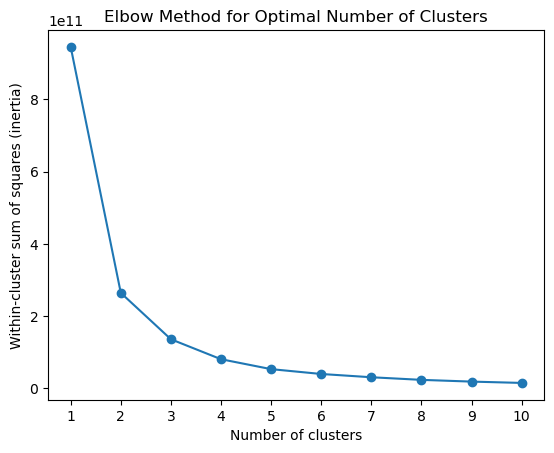

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Frequency,Monetory,kmeans_labels,dbscan_labels,agglo_labels,kmeans_customer_label
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,1529,1441,0,22,1617,0,0,0,1
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,21,15,0,4,27,3,0,1,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,734,692,0,20,776,1,0,2,3
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,48,43,0,6,53,3,0,1,2
4,58293.0,1,0,94,173,43,118,46,27,15,...,1,407,392,0,14,422,0,0,3,1


In [108]:
# Select the desired columns
picked_columns = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 'Age',
                  'marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow',
                 'education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 'education_PhD']
data_subset = data[picked_columns]

# Initialize a list to store the within-cluster sum of squares (inertia) for each number of clusters
inertia = []

# Iterate over possible number of clusters, for example, from 1 to 10
for n_clusters in range(1, 11):
    # Initialize KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # Fit the model using the selected columns for clustering
    kmeans.fit(data_subset)
    # Append the inertia to the list
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (inertia)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 11))
plt.show()

# Initialize KMeans model with n_clusters=4
kmeans = KMeans(n_clusters=4, random_state=0)
# Fit the model using the selected columns for clustering
kmeans.fit(data_subset)

# Add a new column 'kmeans_customer_label' to the original DataFrame
data['kmeans_customer_label'] = kmeans.labels_

data.head()

In [110]:
# Initialize KMeans model with n_clusters=4
kmeans = KMeans(n_clusters=4, random_state=0)
# Fit the model using the selected columns for clustering
kmeans.fit(data_subset)

# Add a new column 'kmeans_customer_label' to the original DataFrame
data['kmeans_customer_label'] = kmeans.labels_

data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Frequency,Monetory,kmeans_labels,dbscan_labels,agglo_labels,kmeans_customer_label
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,1529,1441,0,22,1617,0,0,0,1
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,21,15,0,4,27,3,0,1,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,734,692,0,20,776,1,0,2,3
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,48,43,0,6,53,3,0,1,2
4,58293.0,1,0,94,173,43,118,46,27,15,...,1,407,392,0,14,422,0,0,3,1


In [111]:
data.to_csv('clustering_label.csv', index=False)